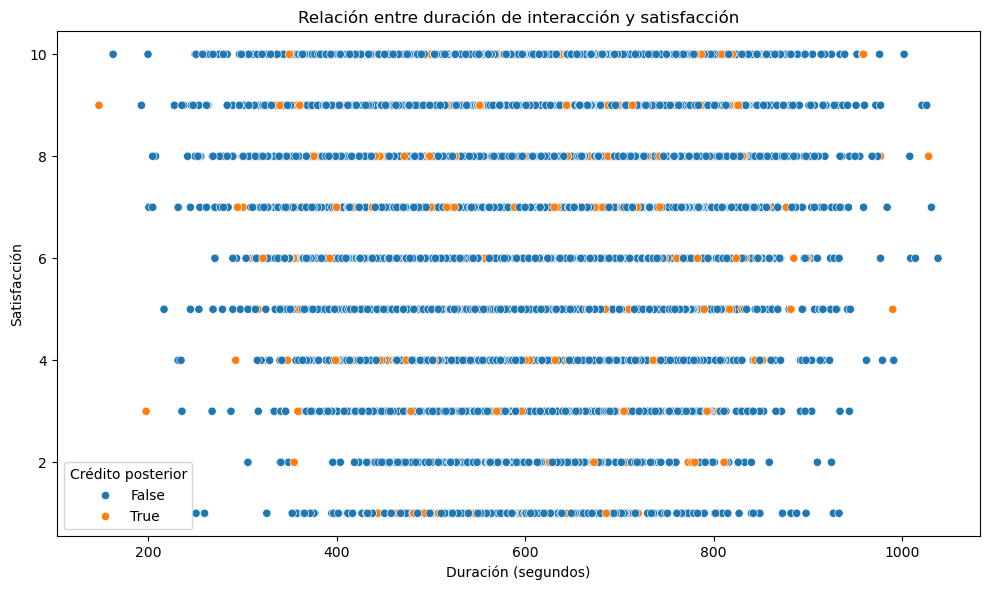

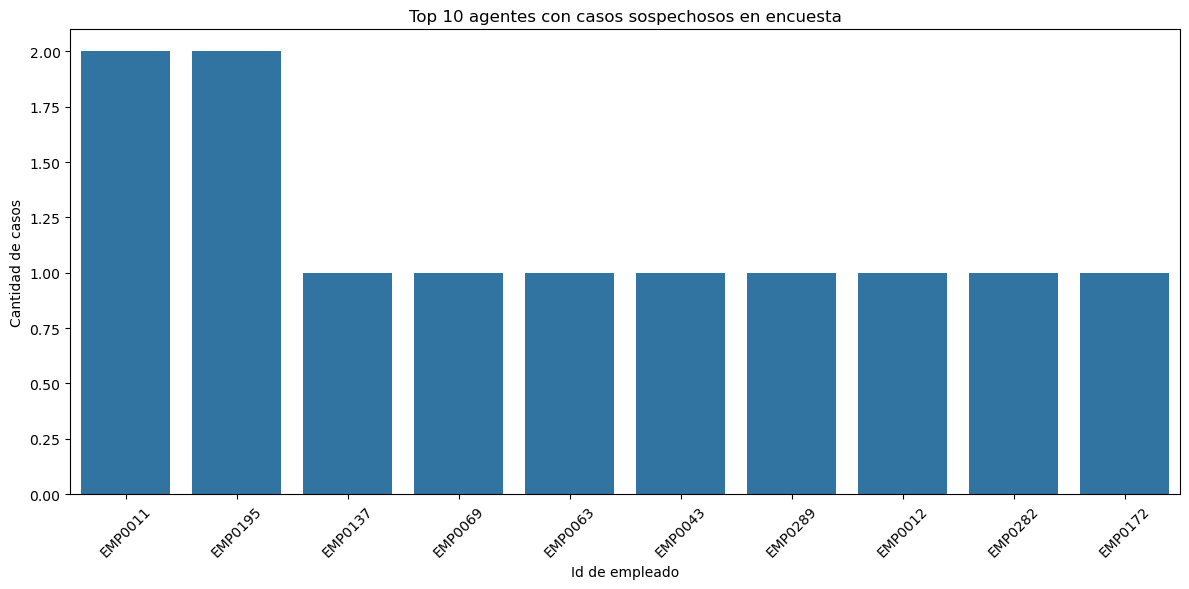

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los archivos desde tu ruta local
df_satisfaccion = pd.read_excel(r"C:\Users\Camilo\OneDrive - UCompensar\2. SEMINARIO DE GRADO\Data\Encuesta_satisfaccion.xlsx")
df_interacciones = pd.read_excel(r"C:\Users\Camilo\OneDrive - UCompensar\2. SEMINARIO DE GRADO\Data\Interacciones.xlsx")
df_creditos = pd.read_excel(r"C:\Users\Camilo\OneDrive - UCompensar\2. SEMINARIO DE GRADO\Data\Creditos.xlsx")

# Asegurar formatos de fecha
df_satisfaccion['Fecha y hora'] = pd.to_datetime(df_satisfaccion['Fecha y hora'])
df_interacciones['Fecha y hora de interacción'] = pd.to_datetime(df_interacciones['Fecha y hora de interacción'])
df_creditos['Fecha y hora de interacción'] = pd.to_datetime(df_creditos['Fecha y hora de interacción'])

# Unificar datos
df_merged = pd.merge(df_satisfaccion, df_interacciones[['Id del caso', 'Duración']], on='Id del caso', how='left')
df_merged = pd.merge(df_merged, df_creditos[['Id del caso', 'Crédito otorgado (USD)']], on='Id del caso', how='left')

# Marcar si hubo acción posterior (crédito)
df_merged['Crédito posterior'] = df_merged['Crédito otorgado (USD)'].notna()

# Detectar outliers de satisfacción (IQR)
Q1 = df_merged['Satisfacción'].quantile(0.25)
Q3 = df_merged['Satisfacción'].quantile(0.75)
IQR = Q3 - Q1
limite_inf = Q1 - 1.5 * IQR
limite_sup = Q3 + 1.5 * IQR
df_merged['Outlier_satisfacción'] = (df_merged['Satisfacción'] < limite_inf) | (df_merged['Satisfacción'] > limite_sup)

# Marcar interacción corta
df_merged['Interacción corta'] = df_merged['Duración'] < 300

# Condición sospechosa: si cumple al menos 2 condiciones
df_merged['Sospechoso'] = df_merged[['Outlier_satisfacción', 'Interacción corta', 'Crédito posterior']].sum(axis=1) >= 2

# Filtrar sospechosos
sospechosos = df_merged[df_merged['Sospechoso'] == True]

# ---------- GRÁFICO 1: Dispersión satisfacción vs duración ----------
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_merged, x='Duración', y='Satisfacción', hue='Crédito posterior')
plt.title('Relación entre duración de interacción y satisfacción')
plt.xlabel('Duración (segundos)')
plt.ylabel('Satisfacción')
plt.tight_layout()
plt.show()

# ---------- GRÁFICO 2: Top 10 agentes sospechosos ----------
plt.figure(figsize=(12, 6))
top_sospechosos = sospechosos['Id de empleado'].value_counts().head(10)
sns.barplot(x=top_sospechosos.index, y=top_sospechosos.values)
plt.title('Top 10 agentes con casos sospechosos en encuesta')
plt.xlabel('Id de empleado')
plt.ylabel('Cantidad de casos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Exportar a Excel si lo deseas
sospechosos.to_excel(r"C:\Users\Camilo\OneDrive - UCompensar\2. SEMINARIO DE GRADO\Data\Satisfaccion_Sospechosa.xlsx", index=False)

# Condición sospechosa: si cumple al menos 2 condiciones
df_merged['Sospechoso'] = df_merged[['Outlier_satisfacción', 'Interacción corta', 'Crédito posterior']].sum(axis=1) >= 2
# Condición adicional: satisfacción muy alta + interacción corta
df_merged['Satisfacción muy alta'] = df_merged['Satisfacción'] >= 9
df_merged['Alta_y_corta'] = df_merged['Satisfacción muy alta'] & df_merged['Interacción corta']

# Sospechoso si:
# - Cumple al menos 2 condiciones entre: outlier, corta, crédito
# - O es alta + corta
df_merged['Sospechoso'] = (
    df_merged[['Outlier_satisfacción', 'Interacción corta', 'Crédito posterior']].sum(axis=1) >= 2
) | df_merged['Alta_y_corta']
